# Find and load Landsat ARD Data using load_ard
This notebook uses the load_ard (load Analysis Ready Data) function to find and load Landsat data. The notebook also calulates the geomedian for the loaded data.



In [1]:
#What can be deleted here?
%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import datacube
import fnmatch
import os
import pandas as pd
import geopandas as gpd

#get the DEA version of the plotting functions
import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
from dea_datahandling import load_ard
import dea_plotting
from dea_plotting import rgb
from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.drivers.netcdf import write_dataset_to_netcdf
import xarray as xr

#Specify output directory
outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

In [3]:
# Connect to datacube containing Landsat data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')


# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples') # need access to project xu18 for ard
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')

#dc = datacube.Datacube(app='load_landsat_example')

In [4]:
# Create a reusable query (can change resolution here if needed)
query = {
    'lat': (-40.188, -40.214),
    'lon': (148.228, 148.268),
    'time': ('2018-01', '2018-06'),
    'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

In [5]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc_landsat,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              **query)

# Print output data
print(ds)

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 20 observations 
<xarray.Dataset>
Dimensions:       (time: 20, x: 127, y: 109)
Coordinates:
  * x             (x) float64 1.4e+06 1.4e+06 1.401e+06 ... 1.404e+06 1.404e+06
  * y             (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * time          (time) datetime64[ns] 2018-01-02T23:54:02.128210 ... 2018-06-27T23:51:21.312814
Data variables:
    nbart_blue    (time, y, x) float32 359.0 378.0 380.0 ... 130.0 198.0 64.0
    nbart_green   (time, y, x) float32 625.0 647.0 667.0 ... 260.0 262.0 336.0
    nbart_red     (time, y, x) float32 662.0 667.0 639.0 ... 240.0 304.0 304.0
    nbart_nir     (time, y, x) float32 3009.0 3102.0

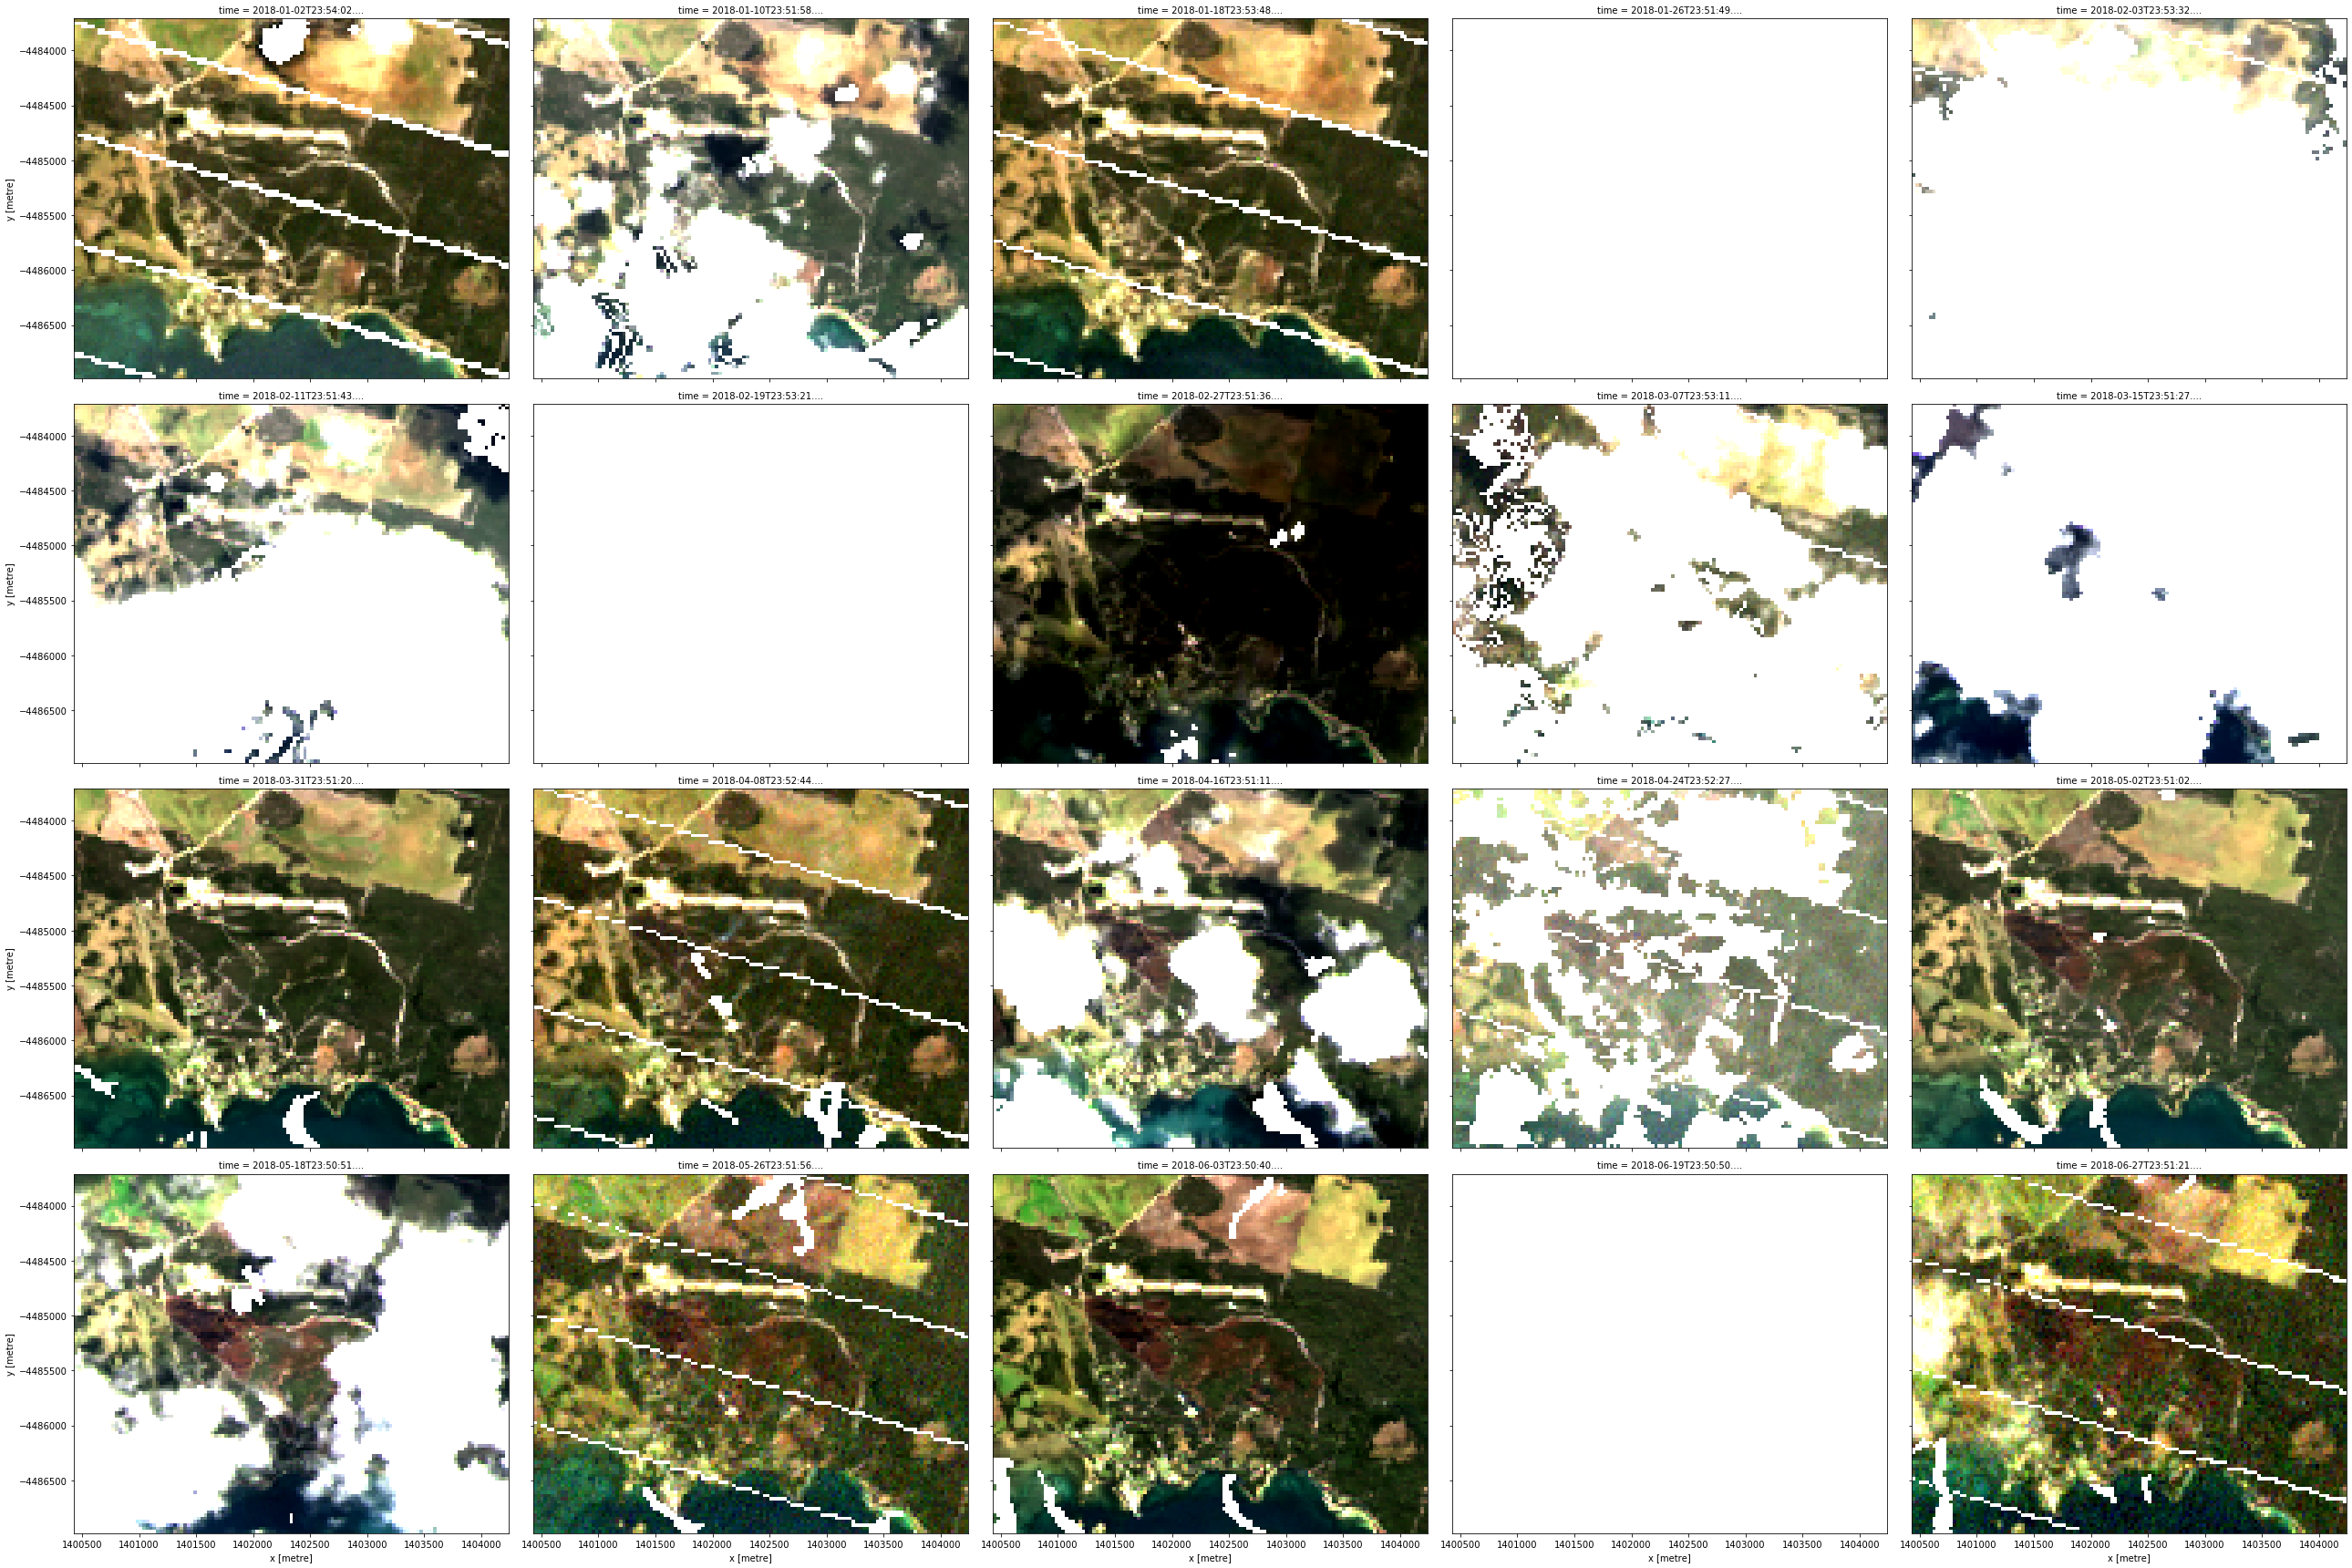

In [6]:
# Plot single observation
#ds.isel(time=6).nbart_nir_1.plot() # Plot time slice 6
#plt.show()

# This will plot all time slices so can take a while for large cubes
rgb(ds, percentile_stretch=(0.05, 0.95), col='time', col_wrap=5)

# Monthly Filter and Geomedian Creation

The cells below run through the process used to filter an existing S2 datacube by month and then produce
a geomedian image. This type of process is useful where only dry season images are required e.g. for producing
dry season composite images.

In [7]:
# function to return months of interest (cm = composite month)
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [8]:
# extract just the months of interest
ds_cm = ds.sel(time=is_cm(ds['time.month']))

ds_cm['time.month'] #take a look at what months we have...

<xarray.DataArray 'month' (time: 14)>
array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-02T23:54:02.128210 ... 2018-04-24T23:52:27.996229

In [9]:
ds_cm

<xarray.Dataset>
Dimensions:       (time: 14, x: 127, y: 109)
Coordinates:
  * x             (x) float64 1.4e+06 1.4e+06 1.401e+06 ... 1.404e+06 1.404e+06
  * y             (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * time          (time) datetime64[ns] 2018-01-02T23:54:02.128210 ... 2018-04-24T23:52:27.996229
Data variables:
    nbart_blue    (time, y, x) float32 359.0 378.0 380.0 ... 516.0 518.0 554.0
    nbart_green   (time, y, x) float32 625.0 647.0 667.0 ... 635.0 598.0 596.0
    nbart_red     (time, y, x) float32 662.0 667.0 639.0 ... 577.0 545.0 509.0
    nbart_nir     (time, y, x) float32 3009.0 3102.0 3367.0 ... 1721.0 1717.0
    nbart_swir_1  (time, y, x) float32 2458.0 2395.0 2323.0 ... 919.0 961.0
Attributes:
    crs:      EPSG:3577

In [10]:
# Compute geomedian here is necessary - either for dataset or subset months
ds_cm_gm = GeoMedian().compute(ds_cm)

In [11]:
ds_cm_gm

<xarray.Dataset>
Dimensions:       (x: 127, y: 109)
Coordinates:
  * x             (x) float64 1.4e+06 1.4e+06 1.401e+06 ... 1.404e+06 1.404e+06
  * y             (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
Data variables:
    nbart_blue    (y, x) float32 545.4954 568.2565 ... 214.65286 221.0001
    nbart_green   (y, x) float32 823.50916 840.18756 ... 316.75613 308.0009
    nbart_red     (y, x) float32 893.7532 918.07806 ... 249.37543 253.0005
    nbart_nir     (y, x) float32 2849.1543 2947.197 ... 1687.7087 1636.0
    nbart_swir_1  (y, x) float32 3049.4983 2969.3267 ... 893.6088 861.0002
Attributes:
    crs:      EPSG:3577

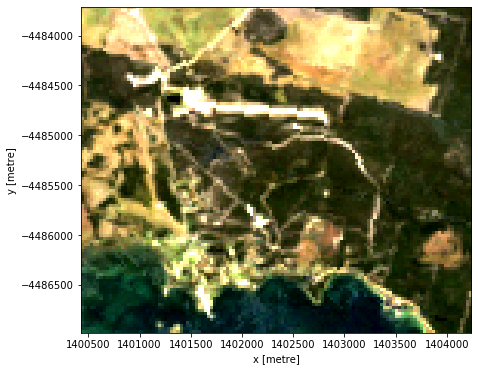

In [12]:
# Plot geomedian image
rgb(ds_cm_gm, percentile_stretch=(0.05, 0.95))

In [13]:
# Here we can export the geomedian
# There is no time dimension so the next line can be ignored
#rgb_tiff = ds.isel(time=1)

# Write multi-band GeoTIFF to a location
write_geotiff(outputdir + 'Landsat_gomedian.tif', ds_cm_gm)